### Table of Contents

[Introduction](#introduction)

[Data](#data)

[Methodology](#methodology)

[Results](#results)

[Discussion](#discussion)

[Conclusion](#conclusion)

<a id="introduction"></a>
## Introduction

In the labs for Week 3, we examined how the neighborhoods of a large metropolitan city (New York or Toronto) could be segmented according to the types of business locations found in each neigborhood. In this project, I would like to examine types of business across multiple major metropolitan areas across the United States.

### Battle of the Cities

I call this project 'Battle of the Cities'. The primary question I would like to answer is

* Can we differentiate the major metropolitan areas of the United states by looking at the types of locations, and the proportions of each type, within those cities?
* Can we derive meaningful neighborhood profiles that will distinguish one major city from another? 

I will examine various neighborhoods within multiple cities, and obtain the locations of interest within each neighborhood using the FourSquare API. Each 'location of interest' is categorized by the FourSquare API into one of about 2,000 categories. So I can use the proportion of each category to make a statistical profile of each neighborhood.

### Background

Many people would like to understand what are the characteristics of the various big cities in the U.S. Interested parties would certainly include people who are relocating, and who would like to settle in a city which would be most agreeable to their particular life style and tastes. But the characterizations can also be of use to 

* Realtors, who have clients that are moving from one area of the country to another
* Marketing professionals, who would like to target advertising to each city. If the characteristics of each city are understood, marketing campaigns can be tailored to each city, and thereby made more effective
* City Planners, who would like to understand the unique characteristics of each city
* Small Business owners, who would like to establish a new business in a particular city

<a id="data"></a>
### Data

Data is primarily location categories collected from FourSquare. But there are three steps

1. Select 12 major U.S. Cities. (I selected these based on nothing other than what I thought would be interesting). For each of these cities, I needed to collect the latitude and longitude of the city center, which I did by scraping off of Wikipedia
2. Define 50 random neighborhoods within each city, where the center of the neighborhood was bounded by an approximate 10 mile square from the city center. (So city center +/- 5 miles).
3. This gives 600 neighborhoods. Use the FourSquare API to collect all the location categories within 500 meters of the neighborhood center

#### Extract Latitude and Longitude of Major Cities (Geocoding)
1. Extract the latitude and longitude of about 12 major U.S. Cities from Wikipedia. Compute the minimum and maximum latitude and longitude for each city, to enclose an area of points within 5 miles of the center of the city.

First, we make a dataframe that consists of the city names that we are interested in. We need to spell it exactly as it appears on the Wikipedia page at 

https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population


In [59]:
import math

import pandas as pd
import numpy as np

In [30]:
dfCitiesProject = pd.DataFrame(
  [
      ['New York', 'NY']
    , ['Detroit', 'MI']
    , ['New Orleans', 'LA']
    , ['Honolulu', 'HI']
    , ['San Francisco', 'CA']
    , ['Los Angeles', 'CA']
    , ['Des Moines', 'IA']
    , ['Anchorage','AK']
    , ['Chicago', 'IL']
    , ['Dallas', 'TX']
    , ['Philadelphia', 'PA']
    , ['Phoenix', 'AZ']
  ]
  , columns = ['City', 'State']
)
dfCitiesProject.head()

,City,State
0,New York,NY
1,Detroit,MI
2,New Orleans,LA
3,Honolulu,HI
4,San Francisco,CA


Now scrape the table of Major US Cities with Longitude and Latitude from Wikipedia. We have to experiment a bit to find the ordinal index of the table that we need

In [42]:
sMajorUsCitiesUrl = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'
dfList = pd.read_html( sMajorUsCitiesUrl, encoding="utf8") 
print( f"Found {len(dfList)} tables")
for dfIndex, dfTable in enumerate( dfList):
    if dfIndex > 0:
        print( '------')
        print()    
    print( f"Table {dfIndex}:")
    print( dfTable.head())
    
# for dfTable in pd.read_html( sMajorUsCitiesUrl):
#    dfTable.head()


Found 12 tables
Table 0:
                                          0
0  Map all coordinates using: OpenStreetMap
1        Download coordinates as: KML · GPX
------

Table 1:
                     Population tablesof U.S. cities
0                                             Cities
1  Population AreaDensityEthnic identityForeign-b...
2                                        Urban areas
3             Populous cities and metropolitan areas
4                                 Metropolitan areas
------

Table 2:
                                                   0
0  Map this section's coordinates using: OpenStre...
1                 Download coordinates as: KML · GPX
------

Table 3:
    0                               1
0 NaN                   State capital
1 NaN              State largest city
2 NaN  State capital and largest city
3 NaN                 Federal capital
------

Table 4:
   2018rank         City    State[c]  2018estimate  2010Census   Change  \
0         1  New York[d]    New Y

So there are 12 tables on the Wikipedia page, and we want the data from the table at index <code>dfList[4]</code>. We just need the columns <code>'City'</code> and <code>'Location'</code>. 

In [77]:
dfCitiesGeocoded = dfList[4][['City', 'Location']].copy()
# Strip off the footnotes from the City name. The footnotes are in squackets []
dfCitiesGeocoded['City'] = dfCitiesGeocoded['City'].str.split('[').str[0].str.strip()
# Strip off the first half of the location in degreees, minutes, seconds to get the decimal
dfCitiesGeocoded['Location'] = dfCitiesGeocoded['Location'].str.split('/').str[1].str.strip()
# Now break the Location into Longitude and Latitude
# (We can ignore N/S for Latitude and E/W for Longitude, because everything is N and W)
dfCitiesGeocoded['Latitude'] = dfCitiesGeocoded['Location'].str.split(' ').str[0].str.strip().str[:-2].str[1:].astype( float)
dfCitiesGeocoded['Longitude'] = dfCitiesGeocoded['Location'].str.split(' ').str[1].str.strip().str[:-2]
dfCitiesGeocoded.head()


,City,Location,Latitude,Longitude
0,New York,﻿40.6635°N 73.9387°W,40.6635,73.9387
1,Los Angeles,﻿34.0194°N 118.4108°W,34.0194,118.4108
2,Chicago,﻿41.8376°N 87.6818°W,41.8376,87.6818
3,Houston,﻿29.7866°N 95.3909°W,29.7866,95.3909
4,Phoenix,﻿33.5722°N 112.0901°W,33.5722,112.0901


Now we can join the 12 chosen cities (in <code>dfCitiesProject</code>) with the geolocation information extracted from Wikipedia (in <code>dfCitiesGeocoded</code>) to give the information we need

In [101]:
dfMerged = pd.merge( dfCitiesProject, dfCitiesGeocoded, on=['City', 'City'])[['City', 'State', 'Latitude', 'Longitude']].copy()
dfMerged

,City,State,Latitude,Longitude
0,New York,NY,40.6635,73.9387
1,Detroit,MI,42.3830,83.1022
2,New Orleans,LA,30.0534,89.9345
3,Honolulu,HI,21.3243,157.8476
4,San Francisco,CA,37.7272,123.0322
5,Los Angeles,CA,34.0194,118.4108
6,Des Moines,IA,41.5726,93.6102
7,Anchorage,AK,61.1743,149.2843
8,Chicago,IL,41.8376,87.6818
9,Dallas,TX,32.7933,96.7665


In [120]:
MILES_PER_DEGREE = 69.05
MILES_SAMPLE = 5.0

# Calculate the minimum and maximum longitude and Latitude for each city
dfMerged['LatitudeRange'] = MILES_SAMPLE / MILES_PER_DEGREE
dfMerged['LongitudeRange'] = (MILES_SAMPLE / MILES_PER_DEGREE) / np.cos( np.radians( dfMerged.Latitude))
dfMerged


,City,State,Latitude,Longitude,LatitudeRange,LongitudeRange
0,New York,NY,40.6635,73.9387,0.072411,0.095460
1,Detroit,MI,42.3830,83.1022,0.072411,0.098031
2,New Orleans,LA,30.0534,89.9345,0.072411,0.083658
3,Honolulu,HI,21.3243,157.8476,0.072411,0.077733
4,San Francisco,CA,37.7272,123.0322,0.072411,0.091552
5,Los Angeles,CA,34.0194,118.4108,0.072411,0.087364
6,Des Moines,IA,41.5726,93.6102,0.072411,0.096792
7,Anchorage,AK,61.1743,149.2843,0.072411,0.150185
8,Chicago,IL,41.8376,87.6818,0.072411,0.097191
9,Dallas,TX,32.7933,96.7665,0.072411,0.086139


#### Define 50 random neighborhoods in each city
2. Define about 50 random points within each of these 10 mile squares, which will be the center of a neighborhood and will be used as a parameter to invoke the FourSquare API

The resulting DataFrame <code>dfNeighborhoods</code> has a columns 
* **.City** is a zero based index to the city in <code>dfMerged</code>
* **.Neighborhood** is a zero based index to a particular neighborhood. So each city has 50 rows, with <code>dfNeighborhood.Neighborhood = 0 .. 49</code>
* **.Latitude** and
* **.Longitude** define the center of the neighborhood. It should be within about 5 miles of the center of the city.

In [138]:
from itertools import product
lstCities = list( range( 0,12))
lstNeighborhoods = list( range( 0, 50))
dfNeighborhoods = pd.DataFrame( list( product( lstCities, lstNeighborhoods)), columns=['City', 'Neighborhood'])
np.random.seed( 101)
dfNeighborhoods['Longitude'] = dfMerged.Longitude[ dfNeighborhoods.City].to_numpy().astype(float) \
  + (np.random.rand( dfNeighborhoods.shape[0]) \
     * 2 - 1) * dfMerged.LongitudeRange[ dfNeighborhoods.City].to_numpy().astype(float)
np.random.seed( 102)
dfNeighborhoods['Latitude'] = dfMerged.Latitude[ dfNeighborhoods.City].to_numpy().astype(float) \
  + (np.random.rand( dfNeighborhoods.shape[0]) \
     * 2 - 1) * dfMerged.LatitudeRange[ dfNeighborhoods.City].to_numpy().astype(float)
dfNeighborhoods

,City,Neighborhood,Longitude,Latitude
0,0,0,73.941831,40.677647
1,0,1,73.952192,40.688987
2,0,2,73.848676,40.634431
3,0,3,73.875987,40.696916
4,0,4,73.974073,40.674903
5,0,5,74.002448,40.708253
6,0,6,73.901846,40.615310
7,0,7,74.013849,40.636294
8,0,8,73.980997,40.642925
9,0,9,73.879503,40.662305


#### Collect Neighborhood data from FourSquare

3. Invoke the FourSquare API to return up to 125 venues for each neighborhood. We will collect the Category of each returned Venue.

First, retrieve the FourSquare credentials ans other configuration from a .cfg file. The .cfg is a simple text file that looks like this

<code>
[DEFAULT]
CLIENT_ID = 2DO54SC4HMRSZOCKMQQXKXAYX3XBT4VHQPHOINJBATHGLVTK
CLIENT_SECRET = &lt;secret&gt;
VERSION = 20180605
LIMIT = 125
RADIUS = 500
</code>

The resulting DataFrame <code>dfNeighborhoods</code> has a columns 
* **CLIENT_ID** is the public CLIENT_ID for FourSquare API
* **CLIENT_SECRET** is the private API Key for FourSquare. (If you want to copy this code, you should substitute your own values for CLIENT_ID and CLIENT_SECRET)
* **VERSION** is the API Version which we must pass on every FourSquare API invocation
* **LIMIT** is the maximum number of results to return on each invocation.
* **RADIUS** is the radius in meters of the venues to be retrieved

In [219]:
import configparser

config = configparser.ConfigParser()
config.read( 'BattleOfCitiesExecution.cfg')
dicParms = config['DEFAULT']
CLIENT_ID = dicParms[ 'CLIENT_ID']
CLIENT_SECRET = dicParms[ 'CLIENT_SECRET']
VERSION = dicParms[ 'VERSION']
LIMIT = dicParms[ 'LIMIT']
RADIUS = dicParms[ 'RADIUS']

print( f"CLIENT_ID={CLIENT_ID}")
print( f"VERSION={VERSION}")
print( f"LIMIT={LIMIT}")
print( f"RADIUS={RADIUS}")


CLIENT_ID=2DO54SC4HMRSZOCKMQQXKXAYX3XBT4VHQPHOINJBATHGLVTK
VERSION=20180605
LIMIT=250
RADIUS=400


We will use a function almost identical to what was supplied in the lab 'Segmenting Toronto', which will retrieve all the venues for a single neighborhood, which is defined by longitude and latitude.

In [210]:
def getNearbyVenues(iCitys, iNeighborhoods, latitudes, longitudes):
    
    venues_list=[]
    for iCity, iNeighborhood, lat, lng in zip(iCitys, iNeighborhoods, latitudes, longitudes):
 #      print( f"{iCity},{iNeighborhood}")
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            -lng, 
            RADIUS, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['venues']

        # return only relevant information for each nearby venue
        if( len( results) > 0):
            for v in results:
                catName = v['categories'][0]['name'] if len( v['categories']) > 0 else 'No Category'
                venues_list.append([(
                    iCity, iNeighborhood, 
                    lat, lng, 
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    catName)])
        else:
            venues_list.append( [(
                iCity, iNeighborhood, lat, lng, '', 0, 0, 'No Venues'
            )])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [216]:
for iCity in range( 0, 4):
    sCity = dfMerged.City[ iCity]
    print( sCity)
    dfCityNeighborhoods = dfNeighborhoods.loc[dfNeighborhoods['City'] == iCity]
    dfSampleVenues = getNearbyVenues(
          dfCityNeighborhoods['City']
        , dfCityNeighborhoods['Neighborhood']
        , dfCityNeighborhoods['Latitude']
        , dfCityNeighborhoods['Longitude']
    )
    print(dfSampleVenues.shape)
    dfSampleVenues.to_csv( f"{sCity}.csv")


New York
(5224, 8)
Detroit
(5764, 8)
New Orleans
(5594, 8)
Honolulu
(5448, 8)


In [217]:
for iCity in range( 4, 8):
    sCity = dfMerged.City[ iCity]
    print( sCity)
    dfCityNeighborhoods = dfNeighborhoods.loc[dfNeighborhoods['City'] == iCity]
    dfSampleVenues = getNearbyVenues(
          dfCityNeighborhoods['City']
        , dfCityNeighborhoods['Neighborhood']
        , dfCityNeighborhoods['Latitude']
        , dfCityNeighborhoods['Longitude']
    )
    print(dfSampleVenues.shape)
    dfSampleVenues.to_csv( f"{sCity}.csv")


San Francisco
(215, 8)
Los Angeles
(5230, 8)
Des Moines
(5462, 8)
Anchorage
(652, 8)


In [220]:
for iCity in range( 8, 12):
    sCity = dfMerged.City[ iCity]
    print( sCity)
    dfCityNeighborhoods = dfNeighborhoods.loc[dfNeighborhoods['City'] == iCity]
    dfSampleVenues = getNearbyVenues(
          dfCityNeighborhoods['City']
        , dfCityNeighborhoods['Neighborhood']
        , dfCityNeighborhoods['Latitude']
        , dfCityNeighborhoods['Longitude']
    )
    print(dfSampleVenues.shape)
    dfSampleVenues.to_csv( f"{sCity}.csv")


Chicago
(5595, 8)
Dallas
(5810, 8)
Philadelphia
(5251, 8)
Phoenix
(5619, 8)


In [218]:
dfMerged.to_csv( 'Cities.csv')
dfNeighborhoods.to_csv( 'Neighborhoods.csv')
dfSampleVenues.to_csv( 'Venues.csv')
dfTest = pd.read_csv( 'Cities.csv')
dfTest.head()

,Unnamed: 0,City,State,Latitude,Longitude,LatitudeRange,LongitudeRange
0,0,New York,NY,40.6635,73.9387,0.072411,0.095460
1,1,Detroit,MI,42.3830,83.1022,0.072411,0.098031
2,2,New Orleans,LA,30.0534,89.9345,0.072411,0.083658
3,3,Honolulu,HI,21.3243,157.8476,0.072411,0.077733
4,4,San Francisco,CA,37.7272,123.0322,0.072411,0.091552


In [3]:
dfTest = pd.read_csv( 'Cities.csv')
dfTest.head()

,Unnamed: 0,City,State,Latitude,Longitude,LatitudeRange,LongitudeRange
0,0,New York,NY,40.6635,73.9387,0.072411,0.095460
1,1,Detroit,MI,42.3830,83.1022,0.072411,0.098031
2,2,New Orleans,LA,30.0534,89.9345,0.072411,0.083658
3,3,Honolulu,HI,21.3243,157.8476,0.072411,0.077733
4,4,San Francisco,CA,37.7272,123.0322,0.072411,0.091552


# Checkpoint
At this point, we have collected all the data we will use in the model, and saved everything off into .csv files. We can start building and training the model from this point on, without the need to invoke FourSquare or download data from internet sources

<a id="methodology"></a>
### Methodology
At a high level, I will process the collected data as follows
1. Collect the data I gathered (which was saved in .csv files). I have collected three dataframes -- a dataframe with my 12 selected cities, a dataframe with the coordinates of 600 random neighborhoods, and a dataframe with more than 55,000 locations and location categories found through the FourSquare API
2. I will use PCA (Principal Component Analysis to reduce the number of dimensions of the FourSquare samples. FourSquare has returned 621 categories, and I will reduce that number to some value that is more suitable for k-Means classification.
3. Use a k-Means classifier to segregate the 600 neighborhoods into distinct classes (based on the features which were derived from PCA)
4. Visualize the distribution of those neighborhood classes across the original 12 cities. This is only 12 data points, so I will use data visualization in the form of radar charts (rather than attempting to apply another k-Means classifier or other unsupervised classification algorithm).

In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

First, read in the cities and the random 50 points within each city which form the basis of our neighborhoods

In [2]:
dfCities = pd.read_csv( 'Cities.csv')
dfNeighborhoods = pd.read_csv( 'Neighborhoods.csv')
dfSamples = pd.read_csv( 'New York.csv')
dfSamples.head()

,Unnamed: 0,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,0,0,40.677647,73.941831,Uncommon Charter High School,40.677530,-73.942053,High School
1,1,0,0,40.677647,73.941831,Achievement First Charter High School,40.677642,-73.942166,College Academic Building
2,2,0,0,40.677647,73.941831,Achievement First Network Office,40.677651,-73.942203,Office
3,3,0,0,40.677647,73.941831,Headmasters Unisex,40.677554,-73.941642,Salon / Barbershop
4,4,0,0,40.677647,73.941831,Halal kingston grill,40.677361,-73.941270,Halal Restaurant


The venue category data we collected from FourSquare was saved off into 12 seperate .csv files, one for each city. Let's read those files and concatenate everything into a single dataframe. 

The row index was saved in the .csv files, and comes back as a new column without a column name. We don't need that, so we just drop the column.

In [3]:
dfSampleVenues = pd.concat(
    (pd.read_csv(f"{csv_file}.csv") for csv_file in dfCities['City'])
)
dfSampleVenues = dfSampleVenues.drop(dfSampleVenues.columns[0], axis=1)

In [4]:
#Now dfSampleVenues contains all the locations collected from FourSquare
dfSampleVenues.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,0,40.677647,73.941831,Uncommon Charter High School,40.677530,-73.942053,High School
1,0,0,40.677647,73.941831,Achievement First Charter High School,40.677642,-73.942166,College Academic Building
2,0,0,40.677647,73.941831,Achievement First Network Office,40.677651,-73.942203,Office
3,0,0,40.677647,73.941831,Headmasters Unisex,40.677554,-73.941642,Salon / Barbershop
4,0,0,40.677647,73.941831,Halal kingston grill,40.677361,-73.941270,Halal Restaurant


Get some summary statistics just as a sanity check. We had 600 neighborhoods (50 each in 12 cities), and we asked for up to 125 locations around each neighborhood. But FourSquare actually returns a maximum of 100 locations, so we could have 60,000 locations or rows in our result set. We also know that FourSquare has about 2,000 different category names for locations.

In [5]:
print( f"Sampled Venues: {dfSampleVenues.shape[0]} rows")
print( f"Venue Categories: {dfSampleVenues[ 'Venue Category'].nunique()} unique")

Sampled Venues: 55864 rows
Venue Categories: 621 unique


4. For each neigbborhood, summarize the probability of each category. There could be up to 2,000 categories, so each neighborhood profile would consist of a vector of up to 2,000 probabilities -- one probability for each possible venue category

We didn't wind up with all 2,000 categories. We actually found 621 unique categories. To get the probabilities in each sample neighborhood, we first one-hot encode the category names, then group the result by City + Neighborhood, and take the mean.

In [59]:
dfOneHot = pd.get_dummies( dfSampleVenues[ 'Venue Category'], prefix='', prefix_sep='')
dfSampleOneHot = pd.concat( [dfSampleVenues, dfOneHot], axis=1)
dfSampleGrouped = dfSampleOneHot.groupby( ['City', 'Neighborhood']).mean().reset_index()
dfOneHot


,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5616,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
dfSampleGrouped[ sampleCategories]

,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.008929,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.008929,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.009434,0.000000,0.000000,0.0,0.0,0.0,0.0,0.009434,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.009174,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.008197,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.008197,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.000000,0.008772,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
#If we did this right, then we should end up with 600 rows (12 cities, 
# 50 sample neighborhoods in each city). Summing horizontally should yield 
# a total of 1.0 because each feature represents the probability of a given
# venue category, and the probability of all categories would be 1.0.
sampleCategories = list( dfOneHot.columns)
serSampleCategories = dfSampleGrouped[sampleCategories].sum(axis=1)
serSampleCategories

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
595    1.0
596    1.0
597    1.0
598    1.0
599    1.0
Length: 600, dtype: float64

5. Use a dimension reducing algorithm such as PCA, to reduce the number of features.

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_cats = StandardScaler().fit_transform( dfSampleGrouped[sampleCategories])
PCA_cats = PCA(n_components = 30)
pca_data = pd.DataFrame( PCA_cats.fit_transform( X_cats))
pca_data

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-2.673224,-0.095888,-0.472798,0.411287,-1.179475,-1.140387,0.724986,-0.431334,1.157874,2.221323,...,-0.092293,0.958105,-0.354396,1.372411,-0.127071,-2.242067,0.610297,-0.538343,-0.637406,-0.345572
1,-2.327231,1.034436,-0.141706,-3.323417,-1.691938,-1.129039,-0.753808,-0.988814,-1.723178,-0.605983,...,0.453728,-1.884716,-0.047373,1.265665,2.274449,-0.943096,0.199531,-0.059239,1.474330,0.113796
2,-3.527344,0.737701,-2.646821,-4.808908,1.021534,0.613921,-2.743131,-1.446086,-1.694970,-1.297737,...,4.978518,0.666606,3.659465,1.506849,-4.348159,0.816083,-4.430751,-2.359093,0.837590,-4.419721
3,-2.883270,-0.900036,-0.835382,-0.204593,1.598262,-1.057757,0.264292,-1.047351,-1.889546,2.107670,...,2.696652,-1.403884,0.241179,1.840706,-0.260199,-0.873354,-0.600779,0.221254,0.778450,-3.013565
4,-5.043357,2.281492,-4.128818,-7.834805,3.717399,-2.292211,-2.390371,2.860445,-2.084359,-2.372030,...,-0.409432,-0.918719,-1.834615,-1.147597,5.507134,0.998518,4.605927,3.512894,-1.485546,-0.272375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-2.198500,-0.520717,0.145902,-1.933719,-0.555123,2.656018,-1.450829,2.861273,-1.886867,-1.585947,...,-1.100321,2.360929,-1.592174,0.023652,-2.323500,0.872505,-1.568822,-1.620748,-0.021456,-1.006627
596,-2.958774,0.491346,-0.121979,-2.114122,-0.345173,0.193838,-2.230263,-1.095254,-2.978247,-1.862496,...,2.466375,-0.844401,0.170623,0.360726,-0.542719,0.506145,0.545962,0.396867,0.113549,0.566625
597,-2.203346,-0.077012,-0.573541,-0.775409,-0.040689,2.681264,-0.604019,3.494774,-0.853442,-1.856073,...,-2.974952,3.172697,1.645371,3.389013,-0.923930,0.345220,-2.105174,-3.936648,0.893611,-2.394098
598,-0.062876,2.506170,0.385071,0.977292,-0.955377,1.876123,0.099530,0.864802,-1.744126,-1.562430,...,0.222905,1.757433,-0.990833,0.537643,-0.646182,-2.898883,1.986820,-2.367006,-0.446982,0.583467


In [8]:
PCA_cats.explained_variance_ratio_

array([0.02041366, 0.01672606, 0.01468019, 0.0139564 , 0.0131524 ,
       0.01179428, 0.01086252, 0.01056172, 0.00995823, 0.00985214,
       0.00926913, 0.00886172, 0.00865841, 0.00822599, 0.00803487,
       0.00778763, 0.0076937 , 0.00741796, 0.007336  , 0.00723031,
       0.00719002, 0.00703821, 0.00690429, 0.00686911, 0.00664335,
       0.0066168 , 0.00644521, 0.00638951, 0.00626496, 0.00616245])

The scree plot shows that the first 5 dimensions returned from PCA explain about 10% of the variance. This is pretty good when you consider that the first 5 dimensions are less than 1% of the original 621. But it is not a very strong correlation.

Nonetheless, I expect that k-Means mapping will give much better results working with 5 dimensions than would be returned with over 600!

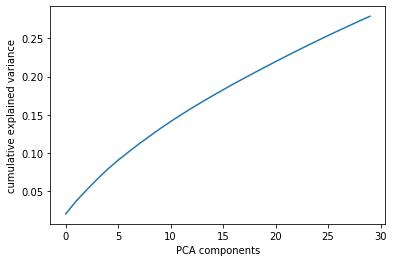

In [9]:
plt.plot(np.cumsum(PCA_cats.explained_variance_ratio_))
plt.xlabel('PCA components')
plt.ylabel('cumulative explained variance')
plt.show()

6. Apply k-Means clustering to segregate the data into some number of categories. This will result in a small number of neighborhood profile classes. 

We don't know what the most effective number of clusters for the model should be. We need to set the number of clusters as a parameter <code>n_clusters=k</code> to build the model. 

To determine the optimal number of clusters, we can plot the cumulative error or cost function J(k) against the chosen number of clusters. The curve will show a greater accuracy for a greater number of clusters, but there will be a point of diminishing return, which will show as an 'elbow' in the curve.

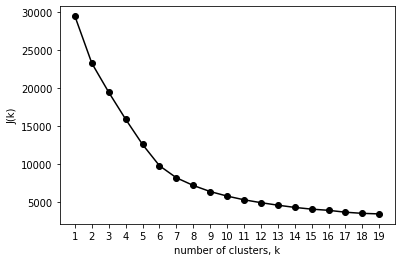

In [10]:
kRange = range(1, 20)
Jk = []
Jk_nonPCA = []
for k in kRange:
    # Create a KMeans instance with k clusters: model
    km_model = KMeans(n_clusters=k)
    
    # Fit model to samples. Measure the effectiveness of each model
    #   by the sum of the squares of distance of each point from the mean
    km_model.fit(pca_data.iloc[:,:5])
    Jk.append(km_model.inertia_)
    
    km_model.fit( dfSampleGrouped)
    Jk_nonPCA.append( km_model.inertia_)
plt.plot( kRange, Jk, '-o', color='black')
plt.xticks( kRange)
plt.xlabel( 'number of clusters, k')
plt.ylabel( 'J(k)')
plt.show()

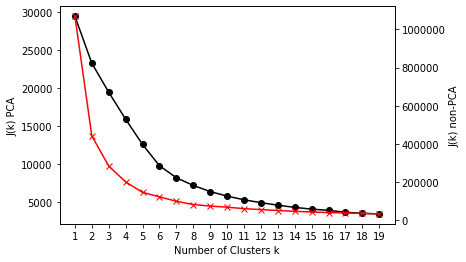

In [11]:
# create figure and axis objects with subplots()
fig,ax1 = plt.subplots()
# Plot J(k) vs k for PCA reduced features
ax1.plot( kRange, Jk, '-o', color='black')
ax1.set_xlabel( "Number of Clusters k")
plt.xticks( kRange)
ax1.set_ylabel( "J(k) PCA")

# twin object for two different y-axis on the sample plot
ax2=ax1.twinx()
# make a plot with different y-axis using second axis object
ax2.plot( kRange, Jk_nonPCA, '-x', color='red')
ax2.set_ylabel("J(k) non-PCA")
plt.show()


7. Plot the results in (perhaps) a bar-chart, which will show each city and the relative proportion of each class of neighborhood profile. We might find that all the bars are nearly equal in height (which means that each city has a similar distribution of neighborhood profiles). Or we might find that some cities have a particular profile which is more common than in other cities.

Whether or not there is a difference from one city to another, we can also look at what lands in each neighborhood profile. 

In [12]:
km_model = KMeans(n_clusters=5,random_state=37)
km_model.fit(pca_data.iloc[:,:5])
dfClasses = pd.DataFrame( km_model.labels_, columns=['Class'])
dfClasses
dfClassified = pd.concat(
    [ dfSampleGrouped[[ 'City', 'Neighborhood']], dfClasses ], axis=1
)
dfClassified

,City,Neighborhood,Class
0,0,0,4
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
595,11,45,0
596,11,46,0
597,11,47,0
598,11,48,4


The above dataframe represents our 600 neighborhoods, and each has been categorized into one of 5 classes (Class0 through Class4). We used PCA to reduce the original dimensionality from over 600 to 5 classes. This solved the 'curse of dimensionality', giving us a manageable number of classes to work with. But there is not a way to assign a meaning to each of these five classes.

We can summarize the count of neighborhoods in each class by City. This lets us see that some cities will have a stronger representation of some classes. We also get a hint of cities that are alike in some way, because they have similar proportions of neighborhoods in each class.

In [13]:
dfOneHot = pd.get_dummies( dfClassified[ 'Class'], prefix='Class', prefix_sep='')
dfClassifiedOneHot = pd.concat( [dfClassified, dfOneHot], axis=1).drop( columns=['Neighborhood', 'Class'])
dfClassifiedGrouped = dfClassifiedOneHot.groupby( ['City']).mean().reset_index()
dfClassifiedGrouped


,City,Class0,Class1,Class2,Class3,Class4
0,0,0.64,0.00,0.18,0.0,0.18
1,1,0.06,0.00,0.02,0.0,0.92
2,2,0.00,0.00,0.00,0.0,1.00
3,3,0.24,0.10,0.44,0.1,0.12
4,4,0.00,1.00,0.00,0.0,0.00
5,5,0.70,0.00,0.22,0.0,0.08
6,6,0.24,0.00,0.08,0.0,0.68
7,7,0.00,1.00,0.00,0.0,0.00
8,8,0.20,0.00,0.18,0.0,0.62
9,9,0.38,0.00,0.02,0.0,0.60


The above dataframe has one row for each city, and the features labelled 'Class0' through 'Class4' are the relative percentages of each type of neighborhood within the city. 

In order to compare these numbers horizontally, we can scale. Some of these classes like Class1 and Class3 are relatively uncommon. Also, scaling will give us a negative number if the relative abundance of a class within a city is less than the average abundance across the whole population. Negative numbers mean that the city does not have as many of a particular class of neighborhood as would be expected based on the total averages.

In [54]:
colOneHot = dfOneHot.columns
dfClassifiedScaled = pd.DataFrame( StandardScaler().fit_transform( dfClassifiedGrouped[colOneHot]), columns = colOneHot)
dfClassifiedScaled

,Class0,Class1,Class2,Class3,Class4
0,1.421948,-0.478488,0.605054,-0.301511,-0.723909
1,-0.923255,-0.478488,-0.657667,-0.301511,1.477567
2,-1.165862,-0.478488,-0.815507,-0.301511,1.715564
3,-0.195434,-0.207646,2.656975,3.316625,-0.902407
4,-1.165862,2.229936,-0.815507,-0.301511,-1.259403
5,1.664555,-0.478488,0.920734,-0.301511,-1.021405
6,-0.195434,-0.478488,-0.184147,-0.301511,0.763575
7,-1.165862,2.229936,-0.815507,-0.301511,-1.259403
8,-0.357172,-0.478488,0.605054,-0.301511,0.585077
9,0.370650,-0.478488,-0.657667,-0.301511,0.525577


<a id="results"></a>
### Results

To visualize this data, I am showing 'radar charts' for each city. A radar chart is built on a polar plot, with one radial spike for each class. The magnitude of the radius along each spike is the relative strenght of that particular class in the given city.

The general shape of the resulting plot will show the distribution of each class of neighborhood within the city. If two given cities have a similar distribution of neighborhood classes, the shape of the radar plots for those two cities will be similar.

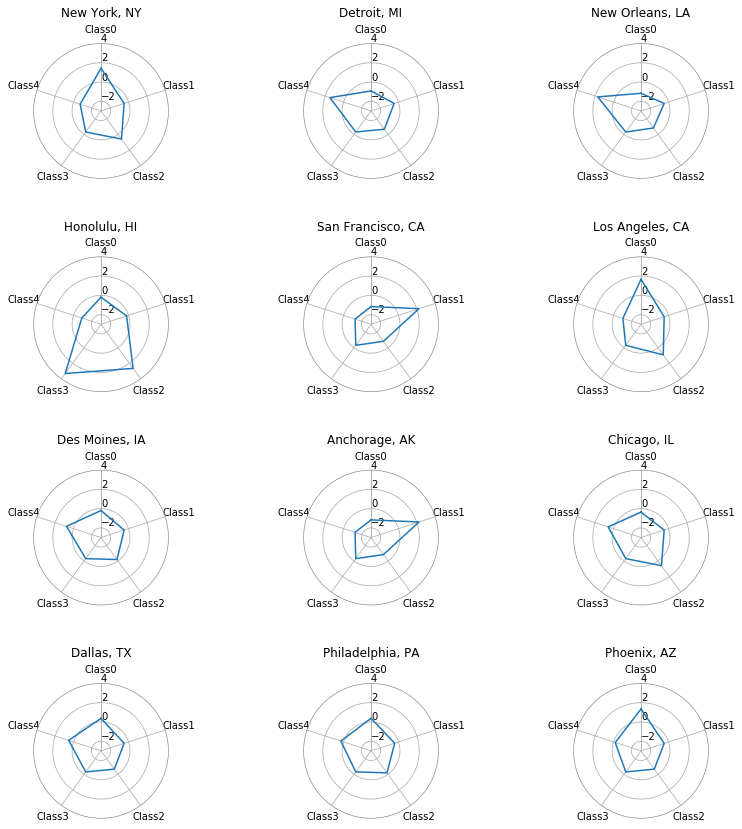

In [66]:
fig, axs = plt.subplots( 4, 3, figsize=(10,12), subplot_kw=dict(projection='polar'))
fig.tight_layout()
fig.subplots_adjust(wspace=1.0)
N = len( colOneHot)
x_ticks = math.pi/180. * np.linspace( 0, 360, N + 1, endpoint=True)
x_ticks
for row in range( 0, 4):
    for col in range( 0, 3):
        ax = axs[ row, col]
        ax.set_theta_offset( math.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)
        ax.set_xticks( x_ticks)
        ax.set_xticklabels( colOneHot)
        
        ax.set_ylim( -3.0, 4.0)

        city = col + 3 * row
        ax.set_title( f"{dfCities['City'][city]}, {dfCities['State'][city]}", pad=20)
        y_vals = dfClassifiedScaled.iloc[city].values
        y_vals = np.append( y_vals, y_vals[:1])
        ax.plot(x_ticks, y_vals, linestyle='solid', zorder=3)
        

### Summary

To carry out this analysis, I chose 12 major U.S. cities (which were chosen by personal choice -- I chose cities that I thought might be interesting, rather than choosing the most populated cities, or random cities within the top 200)

Once the cities were chosen, I chose random points within 500 km of the city center. Each of these random points was considered to be a 'neighborhood', and I chose 50 neighborhoods in each city.

Then I used the 4Square API to find interesting locations within each neighborhood. The 4Square API assigns a category such as 'Fast Food', 'Office Building', 'Nature Trail', etc to each location. This resulted in a dataset of almost 56,000 locations, and more than 600 unique categories. 

To analyze this dataset, I first used one-hot encoding on the categories, then summarized by each neighborhood. This gave me a 600 x ~ 600 dataframe, where each row represented one neighborhood, and each column held the percentage of a given category of location within that neighborhod. 

To deal with the large number of features, I performed PCA (Principal Component Analysis). PCA gives me derived features that can account for most of the variation in the original data, but the categories represented in the original data is lost. Using PCA, I reduced the size of the data to 600 rows x 5 columns.

This 600 x 5 dataframe is now suitable for unsupervised classification, using the k-Means algorithm. I ran the k-Means algorithm for several different numbers of clusters, and plotted the 'inertia' of the model against the number of clusters. This gives a curve that shows the diminishing effect of adding more clusters. For my final model, I chose a number of clusters (5) that was at or near the elbow of the inertia curve.

This results in the assignment of a class (Class0 through Class4) to each of my 600 neighborhoods. Now we want to compare the distribution of neighborhood classes within each city. So I again use on-hot encoding on the class category for each of the 600 neighborhoods, and summarize by city. This results in a 12 x 5 dataframe, one row for each city, and one column for each class of neighborhood.

Finally, to visualize the data, I used radar charts, one for each city, where the axes of the radar chart showed the strength of each category within the city. The shape of the radar chart is based on the distribution of neighborhoods within each city. 

<a id="discussion"></a>
### Discussion

In this project, I analyzed the characteristics of 12 pre-selected major U.S. cities by looking at what types of neighborhoods are present in each city. A 'neighborhood' is defined as a set of locations within a short distance of a given point within the city boundaries. For each neighborhood, I used the FourSquare API to describe the neighborhood in terms of the categories of locations within the neighborhood.

The raw data (collected using the FourSquare API) consisted of a dataframe with 55,864 rows (one row for each location within a neighborhood, and 621 columns (one column for each location category). The values in the dataframe are mostly 0's, with a value of 1 in the column that matches the location category. This data is categorical in nature, so it is not very suitable for application of k-Means mapping. To apply k-Means mapping, we would like to have our columns contain scaled real floating point numbers, which gives k-Means a way to find the Euclidean distance between two points.

This data is first summarized by neighborhood, resulting in a dataframe with 600 rows (one row for each neighborhood), but still has 621 columns (one column for each location category). Now the values of the dataframe represent the percentage of locations in that neighborhood which match the given category. 

We now solved the category problem, because the values in our dataframe are floating point numbers, nicely scaled between 0 and 1. But we still have 621 columns, which gives rise to the 'Curse of Dimensionality'. 

So, to reduce the number of dimensions, I have applied PCA (Principal Component Analsysis). PCA is a procedure from linear algebra that allows us to reduce the dimensionality of our dataset. PCA finds a smaller set of features that can be derived from our original features, but still retains the information from the larger set.

When performing PCA, one of the hyper-parameters that must be given to the algorithm is the number of dimensions to return. To choose the number of dimensions, I plotted a 'scree curve', which plots the number of dimensions across the x-axis, and the explained variance on the y-axis. To choose a good number of dimensions, we can look at the 'elbow' of this curve, which is the point at which adding additional dimensions has diminishing returns to the efficacy of explaining overall variation. From the scree plot, I chose to use PCA with 5 dimensions, in Python <code>PCA_cat = PCA( n_components = 5)</code>. Reading the scree curve, it seems that 5 dimensions should explain about 10% of the variation.

I would have liked to have seen a more pronounced elbow to the scree curve, perhaps showing a low number of dimensions which could explain 40% or more of the variation. I was a little discouraged by the shallowness of the scree curve, but I can see that the dimensions returned through PCA are picking up some amount of variance.

In the raw model, there are 621 dimensions, one for each category. You could therefore expect that each dimension would account for 1/621, or about 0.15% of the variance. So any 5 dimensions would explain less than 1% of the variance. But with PCA, you can see that the most significant 5 dimensions account for at least 10% of the variance, which is a 10-fold increase.

After PCA, we wind up with a dataframe that has 600 rows (one for each neighborhood), and 5 features (one for each of the dimensions derived by PCA). This dataframe, after it is scaled, is much more suitable for k-Means classification.

To apply a k-Means classifier, we must again select a hyperparameter -- what number of clusters do we wish to segregate our data. In order to choose a good value, we can plot the number of clusters across the x-axis, and the total deviation of each point from the centroid as a cost function. Scikit calls this deviation <code><i>model</i>.inertia_</code>. The chart will show a rapid decrease in the total inertia as you add the first few clusters. The total inertia will level out for a higher number of clusters. To find the optimal number of clusters, I considered the inertia to be a cost function, and chose the number of clusters at the elbow of the curve (which was again 5 clusters).

Now, my k-Means classifier is assigning a unique class (<code>Class0</code> through <code>Class4</code>) to each neighborhood. I end up with a dataframe that has 600 rows (one for each neighborhood), and a column with the label of that neighborhood (<code>Class0</code> through <code>Class4</code>). Finally, I summarize this by City, to arrive at a dataframe with 12 rows (one for each city), and 5 features (representing the relative frequency of each neighborhood class in that city).

Because the 5 features were derived from PCA, it is difficult to assign a meaning to the classes. This is one of the problems with PCA -- it reduces dimensionality by finding linear combinations of the existing features which explain the variance. A feature returned via PCA is some linear combination of the original larger number of features. In general, it is not possible to say that PCA Class0 happens because these twenty original features are combined. Each PCA feature is most likely a combination of all 621 original features.

<a id="conclusion"></a>
### Conclusion

The final part of the analysis is to visualize the different distributions of neighborhood classes on each city. I show this distribution using a radar chart. The shape of the radar plot is different for each city, but cities with similar distributions should show a similar shape. And indeed, if you look at the radar charts, you can see similarities between
* New York and Los Angeles (have a greater portion of neighborhoods with 'Class0' and 'Class2')
* Detroit and New Orleans (very strong preponderance of neighborhoods with 'Class4')
* San Francisco and Anchorage (very strong frequency of neighborhoods with 'Class1')
* DesMoines, Dallas and Philadelphia (none of the classes have a strong preponderance. The distribution of neighborhood classes for these cities was within 1/2 standard deviation of the overall frequencies for all cities).

If you look at the radar plots above, you can see that Detroit MI and New Orleans LA are very similar. Both have a strong abundance of neighborhoods belonging to 'Class4' and relatively smaller likelihood of neighborhoods in the other 4 classes (In fact, all of the other classes 'Class0' through 'Class3' are negative, which means that for Detroit and LA, all the other classes are less likely in these two cities than the expected frequency of all cities combined).

The other interesting radar plots are for San Francisco and Anchorage. These two cities have a higher frequency of neighborhoods with 'Class1'. It's not really possible to assign a meaning to 'Class1', because it is derived from PCA. It is some linear combination of the 621 categories returned by FourSquare. But we can look at the neighborhoods for which 'Class1' was assigned, and we find that the types of locations are the types you might associate with a beach -- beaches, islands, marinas, and even undersea diving locations.

So in conclusion, I was able to use a k-Means classifier to classify 600 neighborhoods within 12 major U.S. cities. I used the FourSquare API to find a set of location categories found in each neighborhood, then used PCA to reduce the cardinality of the number of dimensions by neighborhood. Then, I applied  a k-Means classifier to assign a class to each neighborhood, and I could summarize each city by the relative abundance of each neighborhood class. 

I found that major cities do exhibit some difference, which is visualized by the radar charts above. Some cities, such as New York and Los Angeles look very much alike. But I cannot in most cases say exactly what makes these cities alike. To do so would require a deeper analysis of the covariance matrix that was generated with PCA.

### Future Work?

If I were to continue this project, I would try the same thing with more cities -- perhaps as many as 200. Then I could use k-Means classification again on the resulting distributions of neighborhood classifications, and have a more rigid way of determining which cities are similar. In this project, I was working with only 12 cities, which does not really give enough points for a k-Means classifier.

I would also like to test this model for over-fitting. If I start with the same 12 cities, but choose different random neighborhoods, would I get different results? (I think in the case of the beach locations for Class1, the answer is probably no -- it seems that my classifier has picked up on something real in this case).

I could also play with the hyperparameters. I chose to use PCA and generate 5 components out of the original 621 features. I might get better results with more PCA components. I also chose to classify the resulting neighborhoods into 5 classes with the k-Means classifier. Maybe the results would be better with 4 classes or 6.